In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
import numpy as np

In [2]:
import torch
import numpy as np

# 测试 Torch 是否能识别 Numpy
try:
    data = np.array([1, 2, 3])
    tensor = torch.from_numpy(data)
    print("✅ 成功！PyTorch 成功转换了 NumPy 数组：", tensor)
except Exception as e:
    print("❌ 依然报错：", e)

✅ 成功！PyTorch 成功转换了 NumPy 数组： tensor([1, 2, 3])


In [3]:
import SpatialGlue

In [4]:
# Environment configuration. SpatialGlue pacakge can be implemented with either CPU or GPU. GPU acceleration is highly recommend for imporoved efficiency.
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

# the location of R, which is required for the 'mclust' algorithm. Please replace the path below with local R installation path
##os.environ['R_HOME'] = '/scbio4/tools/R/R-4.0.3_openblas/R-4.0.3'

os.environ['R_HOME'] = '/home/aizoo/miniconda3/envs/SpatialGlue/lib/R'

In [5]:
# read data
file_fold = '/data/workspace/ST/0_data/Data_SpatialGlue/Dataset11_Human_Lymph_Node_A1/' #please replace 'file_fold' with the download path

adata_omics1 = sc.read_h5ad(file_fold + 'adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad(file_fold + 'adata_ADT.h5ad')

adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()

/home/aizoo/miniconda3/envs/SpatialGlue/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/aizoo/miniconda3/envs/SpatialGlue/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [6]:
# Specify data type
data_type = '10x'

# Fix random seed
from SpatialGlue.preprocess import fix_seed
random_seed = 2022
fix_seed(random_seed)

In [7]:
from SpatialGlue.preprocess import clr_normalize_each_cell, pca


# RNA
sc.pp.filter_genes(adata_omics1, min_cells=10)
sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_omics1, target_sum=1e4)
sc.pp.log1p(adata_omics1)
sc.pp.scale(adata_omics1)

adata_omics1_high =  adata_omics1[:, adata_omics1.var['highly_variable']]
adata_omics1.obsm['feat'] = pca(adata_omics1_high, n_comps=adata_omics2.n_vars-1)

# Protein
adata_omics2 = clr_normalize_each_cell(adata_omics2)
sc.pp.scale(adata_omics2)
adata_omics2.obsm['feat'] = pca(adata_omics2, n_comps=adata_omics2.n_vars-1)

In [8]:
adata_omics2.n_vars

31

In [9]:
adata_omics1

AnnData object with n_obs × n_vars = 3484 × 17954
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p'
    obsm: 'spatial', 'feat'

In [10]:
from SpatialGlue.preprocess import construct_neighbor_graph
data = construct_neighbor_graph(adata_omics1, adata_omics2, datatype=data_type)

In [11]:
# define model
from SpatialGlue.SpatialGlue_pyG import Train_SpatialGlue
model = Train_SpatialGlue(data, datatype=data_type, device=device)

# train model
output = model.train()

/home/aizoo/miniconda3/envs/SpatialGlue/lib/python3.8/site-packages/SpatialGlue/preprocess.py:132: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:641.)
  return torch.sparse.FloatTensor(indices, values, shape)
  0%|          | 0/200 [00:00<?, ?it/s]/home/aizoo/miniconda3/envs/SpatialGlue/lib/python3.8/site-packages/SpatialGlue/model.py:212: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.alpha = F.softmax(torch.squeeze(self.vu) + 1e-6)
100%|██████████| 200/200 [00:08<00:00, 23.97it/s]

Model training finished!



In [12]:
adata = adata_omics1.copy()
adata.obsm['emb_latent_omics1'] = output['emb_latent_omics1'].copy()
adata.obsm['emb_latent_omics2'] = output['emb_latent_omics2'].copy()
adata.obsm['SpatialGlue'] = output['SpatialGlue'].copy()
adata.obsm['alpha'] = output['alpha']
adata.obsm['alpha_omics1'] = output['alpha_omics1']
adata.obsm['alpha_omics2'] = output['alpha_omics2']

In [13]:
adata

AnnData object with n_obs × n_vars = 3484 × 17954
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'adj_spatial'
    obsm: 'spatial', 'feat', 'adj_feature', 'emb_latent_omics1', 'emb_latent_omics2', 'SpatialGlue', 'alpha', 'alpha_omics1', 'alpha_omics2'

In [14]:
# we set 'mclust' as clustering tool by default. Users can also select 'leiden' and 'louvain'
from SpatialGlue.utils import clustering
tool = 'mclust' # mclust, leiden, and louvain
clustering(adata, key='SpatialGlue', add_key='SpatialGlue', n_clusters=6, method=tool, use_pca=True)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 5.4.10
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [15]:
# 建议先检查一下聚类列名是否为你想要的名称
# adata.write(文件路径)
adata.write("adata_spatialglue_test.h5ad")

/home/aizoo/miniconda3/envs/SpatialGlue/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


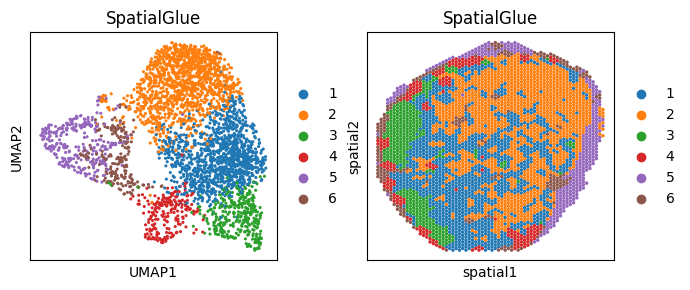

In [16]:
# visualization
import matplotlib.pyplot as plt
fig, ax_list = plt.subplots(1, 2, figsize=(7, 3))
sc.pp.neighbors(adata, use_rep='SpatialGlue', n_neighbors=10)
sc.tl.umap(adata)

sc.pl.umap(adata, color='SpatialGlue', ax=ax_list[0], title='SpatialGlue', s=20, show=False)
sc.pl.embedding(adata, basis='spatial', color='SpatialGlue', ax=ax_list[1], title='SpatialGlue', s=25, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

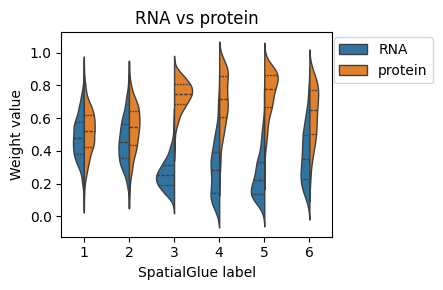

In [17]:
# plotting modality weight values.
import pandas as pd
import seaborn as sns
plt.rcParams['figure.figsize'] = (5,3)
df = pd.DataFrame(columns=['RNA', 'protein', 'label'])
df['RNA'], df['protein'] = adata.obsm['alpha'][:, 0], adata.obsm['alpha'][:, 1]
df['label'] = adata.obs['SpatialGlue'].values
df = df.set_index('label').stack().reset_index()
df.columns = ['label_SpatialGlue', 'Modality', 'Weight value']
##ax = sns.violinplot(data=df, x='label_SpatialGlue', y='Weight value', hue="Modality",
               ## split=True, inner="quart", linewidth=1, show=False)
ax = sns.violinplot(data=df, x='label_SpatialGlue', y='Weight value', hue="Modality",
                split=True, inner="quart", linewidth=1)
ax.set_title('RNA vs protein')
ax.set_xlabel('SpatialGlue label')
ax.legend(bbox_to_anchor=(1.4, 1.01), loc='upper right')

plt.tight_layout(w_pad=0.05)
#plt.show()